<a href="https://colab.research.google.com/github/micakce/nst_Arting/blob/master/Art_Generation_with_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

In [0]:
"""Download necessary files to get the project working"""

# content_images: here we store the images we are going to be working on
# output: here where we store the processed images
!mkdir content_images output

# download respository with userful files, nst_utils and some style images
!git clone https://github.com/micakce/nst_Arting.git

# download the model we are going to be working with
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat


In [0]:
import os
import sys
sys.path.append('nst_Arting/')
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import urllib.request
from nst_utils import *
import numpy as np
import tensorflow as tf
from google.colab import files
import imageio
import math

%matplotlib inline

### Main functions definition

#### compute_content_cost

difference between the content image and the generated image: 
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [0]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, [n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H*n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

#### gram_matrix(A): 
Calculates de correlation between filters:
$G_A = AA^T$

In [0]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, A, transpose_b=True)
    
    return GA

#### compute_layer_style_cost(a_S, a_G)
Calculate the difference between the filter correlation (Gram Matrices) of the style image and the generated image:
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$


In [0]:
def compute_layer_style_cost(a_S, a_G, a_S_2 = 0):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
        
    if a_S_2 != 0:
        a_S_2 = tf.transpose(tf.reshape(a_S_2, [n_H*n_W, n_C]))
        a_S = tf.add(a_S, a_S_2)
            
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*(n_C**2)*(n_H*n_W)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

#### compute_style_cost(model, STYLE_LAYERS)
Computes the cost for several layers of the model so style transfer is more efective:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

#### total_cost(J_content, J_style, alpha=10, beta=40)
Computes the total cost in order to minimize both the style and the content cost: 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

#### readImageFromURL

Makes it easy to work with files that are online, you can get the image right from the URL without having to save it on the server.

In [0]:
def readImageFromURL(url, width=0, height=0, content=0):
  """
  Read images right from URLs
  
  Arguments:
  url -- URL of the image
  width -- Width of the output image
  height -- Height of the output image
  """
  image = np.array(Image.open(urllib.request.urlopen(url)))

  # if both set, use custom size, if not use content image size
  if width and height:
    CONFIG.IMAGE_WIDTH = width
    CONFIG.IMAGE_HEIGHT = height
  elif content:
    CONFIG.IMAGE_WIDTH = image.shape[1]
    CONFIG.IMAGE_HEIGHT = image.shape[0]

  image = np.array(Image.fromarray(image).resize((CONFIG.IMAGE_WIDTH,CONFIG.IMAGE_HEIGHT)))
  imshow(image)
  image = reshape_and_normalize_image(image)
  
  return image

## Setting parameters

### Uploading images

#### Uploading pictures from local storage

Here you get prompted to upload an image and, it will be processed and displayed. Make sure to upload always the content image first.

In [0]:
"""Uploading content_image"""
content_image = files.upload()
content_image = imageio.imread('/content/'+list(content_image.keys())[0])
imshow(content_image)
CONFIG.IMAGE_WIDTH = content_image.shape[1]
CONFIG.IMAGE_HEIGHT = content_image.shape[0]
content_image = np.array(Image.fromarray(content_image).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
content_image = reshape_and_normalize_image(content_image)


In [0]:
"""Uploading style_image"""
style_image = files.upload()
style_image = imageio.imread('/content/'+list(style_image.keys())[0])
style_image = np.array(Image.fromarray(style_image).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)
style_images = [(style_image, 1)]


#### Uploading from remote server

You can also use URLs to upload images from the internet. Again, make sure to upload the content image first.

In [0]:
"""Use this to work with images on internet"""

content_URL = 'https://lh3.googleusercontent.com/ORWcTCATPrusFjm_9VcavRGdOcrgOcm7NmNWDTrcIMzlUrhqMMl1_TkW8JpapHWpx8OhUzoBzXaN_hbKKkt4xGnkbObKOW6osOLnwhtwv5kMj3hAiXXXiyaP8tkA95Vsxt1b0c3uLtzSGirWgHrwUdQg9NHt0oVYQgsyyuebHHh2giBPR_NtVBnH47pYPKwkoXJ9QGVd2SXC-G212ea8z6WQq99YLjI-WfPZFAXxfOhcTGs-ks4JKLt1ncwpAwzsbuVB4i9RLB4yZ4asOxla2UCUCWjqJmK9gMw7B2UmKZ9PXSoPIZaKD-MtuyOTDwa3kK9kKRwjSh1dGuRLVpayU666fa7WotxKzJ27KUlJNO8zqrfWEOzK1Gzp3dhi-AKqCMDqOlDHODGN-cUK-gP0NYRhFRC9jVG3DXIZyNfPXzuB0Va1Mk52nAqslQ6a_Ol0UXGIX4gAhWK3Hhj9T9hCMUylQ58UZ3qkIDfkcwE2AuW6E386jGIxKBhsah0PXRbCz5XnQnZsKcXu8RytexrPEC4PzD-0g9nhqErbSJTGxAazJtNPAq--7sX2OEeMq-49kDvDgqLa4zpFAvMTthePLtyGjBJnuP8q_4eaPWJQJSBuFhJTA6P3imitKqDJqJkxWLzXOAkBASza0wQ_i3IQPJzc9PhAfd5k=w433-h577-no'
style_URL = 'https://afremov.com/images/product/MELODY-OF-THE-NIGHT.jpg'

In [0]:
# load content image
content_image = readImageFromURL(content_URL, content=1)

In [0]:
# load style image
style_image = readImageFromURL(style_URL)


#### Using predefined styles

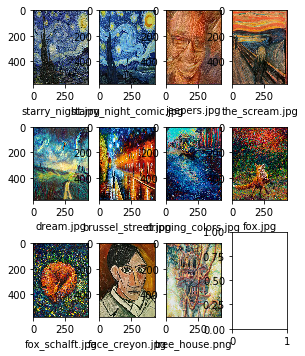

In [0]:
"""Read and show some style images stored in the repo"""
style_images_list = [
    "starry_night.jpg",
    "starry_night_comic.jpg",
    "jeepers.jpg",
    "the_scream.jpg",
    "dream.jpg",
    "brussel_street.jpg",
    "dripping_colors.jpg",
    "fox.jpg",    
    "fox_schalft.jpg",
    "face_creyon.jpg",
    "tree_house.png",
]

l = len(style_images_list)
y = 4
x = math.ceil(l / y)

f, axes = plt.subplots(x,y, figsize=(CONFIG.IMAGE_WIDTH/95,CONFIG.IMAGE_HEIGHT/95))

style_images_dict = {}

for i, style in enumerate(style_images_list):
  style_im = imageio.imread("/content/nst_Arting/style_images/"+style)
  style_im = np.array(Image.fromarray(style_im).resize((CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT)))
#   Image.fromarray(style_im).save(style)
#   files.download('/content/' + style)
  ax = math.floor(i/y)
  ay = (i % y)
  axes[ax,ay].imshow(style_im)
  axes[ax,ay].set_xlabel(style)
  style_images_dict[style] = reshape_and_normalize_image(style_im)
   

In [0]:
"""Uncomment corresponding line to use the desired style, uncomment more than one if you want
to mix styles, also can set the weight for each style"""

style_images = []
# style_images.append((style_images_dict["starry_night.jpg"], 1))
# style_images.append((style_images_dict["starry_night_comic.jpg"], 1))
# style_images.append((style_images_dict["jeepers.jpg"], 1))
style_images.append((style_images_dict["the_scream.jpg"], .35))
style_images.append((style_images_dict["dream.jpg"], .65))
# style_images.append((style_images_dict["brussel_street.jpg"], 1))
# style_images.append((style_images_dict["dripping_colors.jpg"], 1))
# style_images.append((style_images_dict["fox.jpg"], 1))
# style_images.append((style_images_dict["fox_schlaft.jpg"], 1))
# style_images.append((style_images_dict["face_creyon.jpg"], 1))
# style_images.append((style_images_dict["tree_house.png"], 1))



In [0]:
"""Set what layer of the model to use for the style transfer, each layer captures different features
of the image, can also set the weight for each layer"""

STYLE_LAYERS = [
    ('conv1_1', .9), 
    ('conv1_2', .5),
    ('conv2_1', .9),
    ('conv2_2', .9),
    ('conv3_1', .9),
#    ('conv3_2', .9),
#    ('conv4_1', .9),
#    ('conv4_2', .9),
#    ('conv4_3', .9),
#    ('conv4_4', .9),
#    ('conv5_1', .9),
#    ('conv5_2', .5),
#    ('conv5_3', .5),
#    ('conv5_4', .5)
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 577, 433, 3) (1, 577, 433, 3) (1, 577, 433, 3)


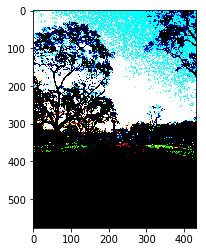

In [0]:
# generate noise image with resemblance to the the content image for faster convergence
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])
print(content_image.shape, style_images[0][0].shape, generated_image.shape)

### Model

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#devices = sess.list_devices()
#for d in devices:
#  print(d.name)



In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [0]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)


J_S = 0
for image in style_images:
  sess.run(model['input'].assign(image[0]))
  J_style = compute_style_cost(model, STYLE_LAYERS)
  J_S += image[1]*J_style

# Total cost
J = total_cost(J_content, J_S)

# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [0]:
def model_nn(sess, input_image, num_iterations = 500):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%50 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_S])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [0]:
model_nn(sess, generated_image, num_iterations=1000)
generated_im = imageio.imread('output/generated_image.jpg')
imshow(generated_im)

In [0]:
files.download('output/generated_image.jpg')


### Miscelaneos

#### Visualize CNN outputs

This code show you what each filter of each layer in the model is looking at when processing the (style) images.

**\#TODO**: Get the nodes/layers that get activated the most when processing the images. With this we get to know what nodes/layers are looking at exactly (patterns/features in the image) and get a better idea of what layers would do better with different kinds of style images.

In [0]:
sess.run(model['input'].assign(style_image_6))
layer_outputs = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 
                 'conv3_2', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 
                 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']
x = len(layer_outputs)
y = 30
f, axarr = plt.subplots(x,y, figsize=(120,42))
#f.figure(figsize=(10,10))
for i,layer in enumerate(layer_outputs):
  out = model[layer]
  im = sess.run(out)
  for j in range(0,y):
    axarr[i,j].imshow(im[0,:,:,j])
    axarr[i,j].grid(False)
    axarr[i,j].set_ylabel(layer)